In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

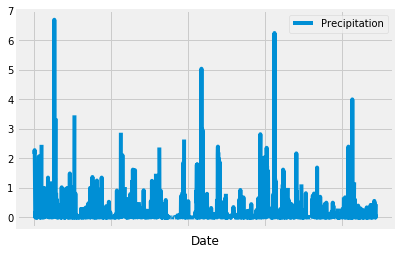

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = dt.datetime.strptime(session.query(func.max(Measurement.date)).scalar(),'%Y-%m-%d')
year_ago = max_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precipitation[:],columns=['Precipitation','Date'])
precip_df.set_index('Date',inplace=True)

# Sort the dataframe by date
precip_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.show()

In [256]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [257]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [258]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_measurements = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_measurements

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [259]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_measurements[0][0]
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).first()

(54.0, 85.0, 71.66378066378067)

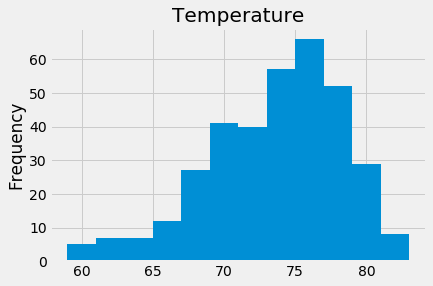

In [260]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.tobs).filter(Measurement.date > year_ago, Measurement.station == most_active_station)

temp_df = pd.DataFrame(temperature[:],columns=['Temperature'])

temp_df.hist(bins=12)
plt.ylabel("Frequency")
plt.show()

In [261]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [317]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#dates only go to Aug 2017, will use two years prior data
my_start_date = dt.datetime.strptime('2018-12-23','%Y-%m-%d')
my_end_date = dt.datetime.strptime('2019-01-02','%Y-%m-%d')

data_start_date = my_start_date - dt.timedelta(days=365*2)
data_end_date = my_end_date - dt.timedelta(days=365*2)

my_trip = calc_temps(data_start_date, data_end_date)
tmin = my_trip[0][0]
tavg = my_trip[0][1]
tmax = my_trip[0][2]

print(tmin,tavg,tmax)

62.0 71.41666666666667 78.0


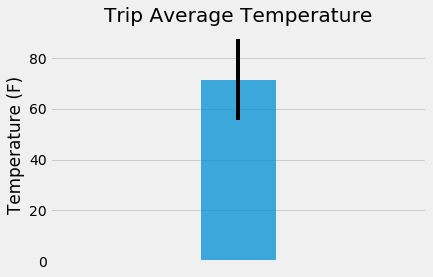

In [318]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(0,height=tavg,width=.2,yerr=(tmax-tmin),alpha=.75)
plt.ylabel("Temperature (F)")
plt.title("Trip Average Temperature")
plt.xticks([])
plt.xlim(-.5,.5)
plt.show()

In [319]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
my_trip_data = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).group_by(Measurement.station).filter(Measurement.station == Station.station, Measurement.date >= data_start_date, Measurement.date <= data_end_date).order_by(func.sum(Measurement.prcp).desc()).all()

trip_df = pd.DataFrame(my_trip_data[:],columns=["Station", "Station Name","Total Precipitation", "Latitude", "Longitude","Elevation"])
trip_df

,Station,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.55,21.33310,-157.80250,152.4
1,USC00513117,"KANEOHE 838.1, HI US",1.85,21.42340,-157.80150,14.6
2,USC00519281,"WAIHEE 837.5, HI US",1.68,21.45167,-157.84889,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.38,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.30,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.22,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [320]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [323]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
total_number_days = int((my_end_date - my_start_date)/dt.timedelta(days=1))

trip_dates = []

for x in range(0,total_number_days+1):
    date = my_start_date + dt.timedelta(days=x)
    trip_dates.append(date)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(dt.datetime.strftime(date,'%m-%d'))[0] for date in trip_dates]
normals

[(61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0),
 (62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0)]

In [346]:
# Load the previous query results into a Pandas DataFrame and add the `trip_days` range as the `date` index
trip_normals_df = pd.DataFrame(normals[:],columns=["tmin","tavg","tmax"])
string_dates = [dt.datetime.strftime(date,'%Y-%m-%d') for date in trip_dates]
trip_normals_df.set_index([string_dates],inplace=True)
trip_normals_df

,tmin,tavg,tmax
2018-12-23,61.0,70.346939,78.0
2018-12-24,62.0,70.062500,78.0
2018-12-25,60.0,71.750000,79.0
2018-12-26,63.0,71.446809,77.0
2018-12-27,62.0,71.916667,79.0
2018-12-28,62.0,70.520833,77.0
2018-12-29,57.0,70.291667,78.0
2018-12-30,63.0,69.863636,76.0
2018-12-31,56.0,68.279070,77.0
2019-01-01,62.0,69.153846,77.0


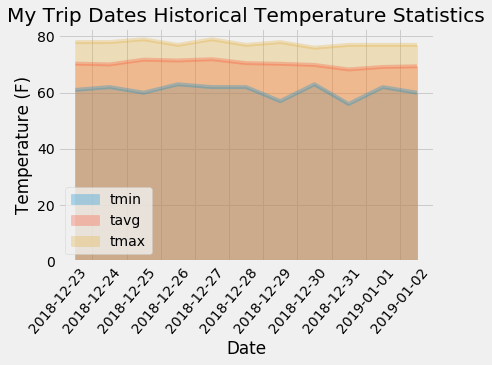

In [372]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot.area(stacked=False,alpha=.3)
plt.title("My Trip Dates Historical Temperature Statistics")
plt.ylabel("Temperature (F)")
plt.xlabel("Date")
plt.xticks(np.arange(-.5,len(string_dates)),string_dates,rotation=50)
plt.show()